In [1]:
!pip install ydata-profiling
!pip install implicit==0.7.2 scipy==1.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... do

In [31]:
import os
import warnings
import random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from scipy.sparse import coo_matrix
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, precision_recall_fscore_support, precision_recall_curve,  precision_score, recall_score, f1_score, accuracy_score
from xgboost import XGBClassifier


In [2]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

In [3]:
PATH = "/content/dataset testing 5 november 2025.csv"
df = pd.read_csv(PATH)

print("Shape:", df.shape)
display(df.head())

Shape: (10000, 19)


,customer_id,plan_type,device_brand,avg_data_usage_gb,pct_video_usage,avg_call_duration,sms_freq,monthly_spend,topup_freq,travel_score,complaint_count,product_id,product_name,spending_tier,duration,streaming,gaming,social_media,target_offer
0,C00001,Prepaid,Realme,1.50,0.804146,7.98,13,70000,4,0.284419,0,1,10gb 50k (internet only 1),low,30 hari,no,no,no,General Offer
1,C00002,Postpaid,Vivo,1.09,0.107686,9.56,9,63000,3,0.115086,0,18,20gb 45k (internet + stream mingguan),low,7 hari,yes,no,no,Streaming partner offer
2,C00003,Postpaid,Xiaomi,3.24,0.313894,4.61,13,89000,7,0.402998,0,15,10gb 15k (internet only harian 2),mid,1 hari,no,no,no,General Offer
3,C00004,Prepaid,Apple,5.32,0.420158,6.96,8,67000,4,0.302169,0,2,15gb 65k (internet only 2),low,30 hari,no,no,no,General Offer
4,C00005,Prepaid,Huawei,1.91,0.251638,11.01,21,72000,5,0.487911,0,23,3gb 8k (internet only hemat 1),low,1 hari,no,no,no,General Offer


In [4]:
print("\nDtypes:")
print(df.dtypes)

mem_mb = df.memory_usage(deep=True).sum() / 1024**2
print(f"\nMemory usage: {mem_mb:.2f} MB")


Dtypes:
customer_id           object
plan_type             object
device_brand          object
avg_data_usage_gb    float64
pct_video_usage      float64
avg_call_duration    float64
sms_freq               int64
monthly_spend          int64
topup_freq             int64
travel_score         float64
complaint_count        int64
product_id             int64
product_name          object
spending_tier         object
duration              object
streaming             object
gaming                object
social_media          object
target_offer          object
dtype: object

Memory usage: 6.23 MB


## Missing Values

,missing_count,missing_pct


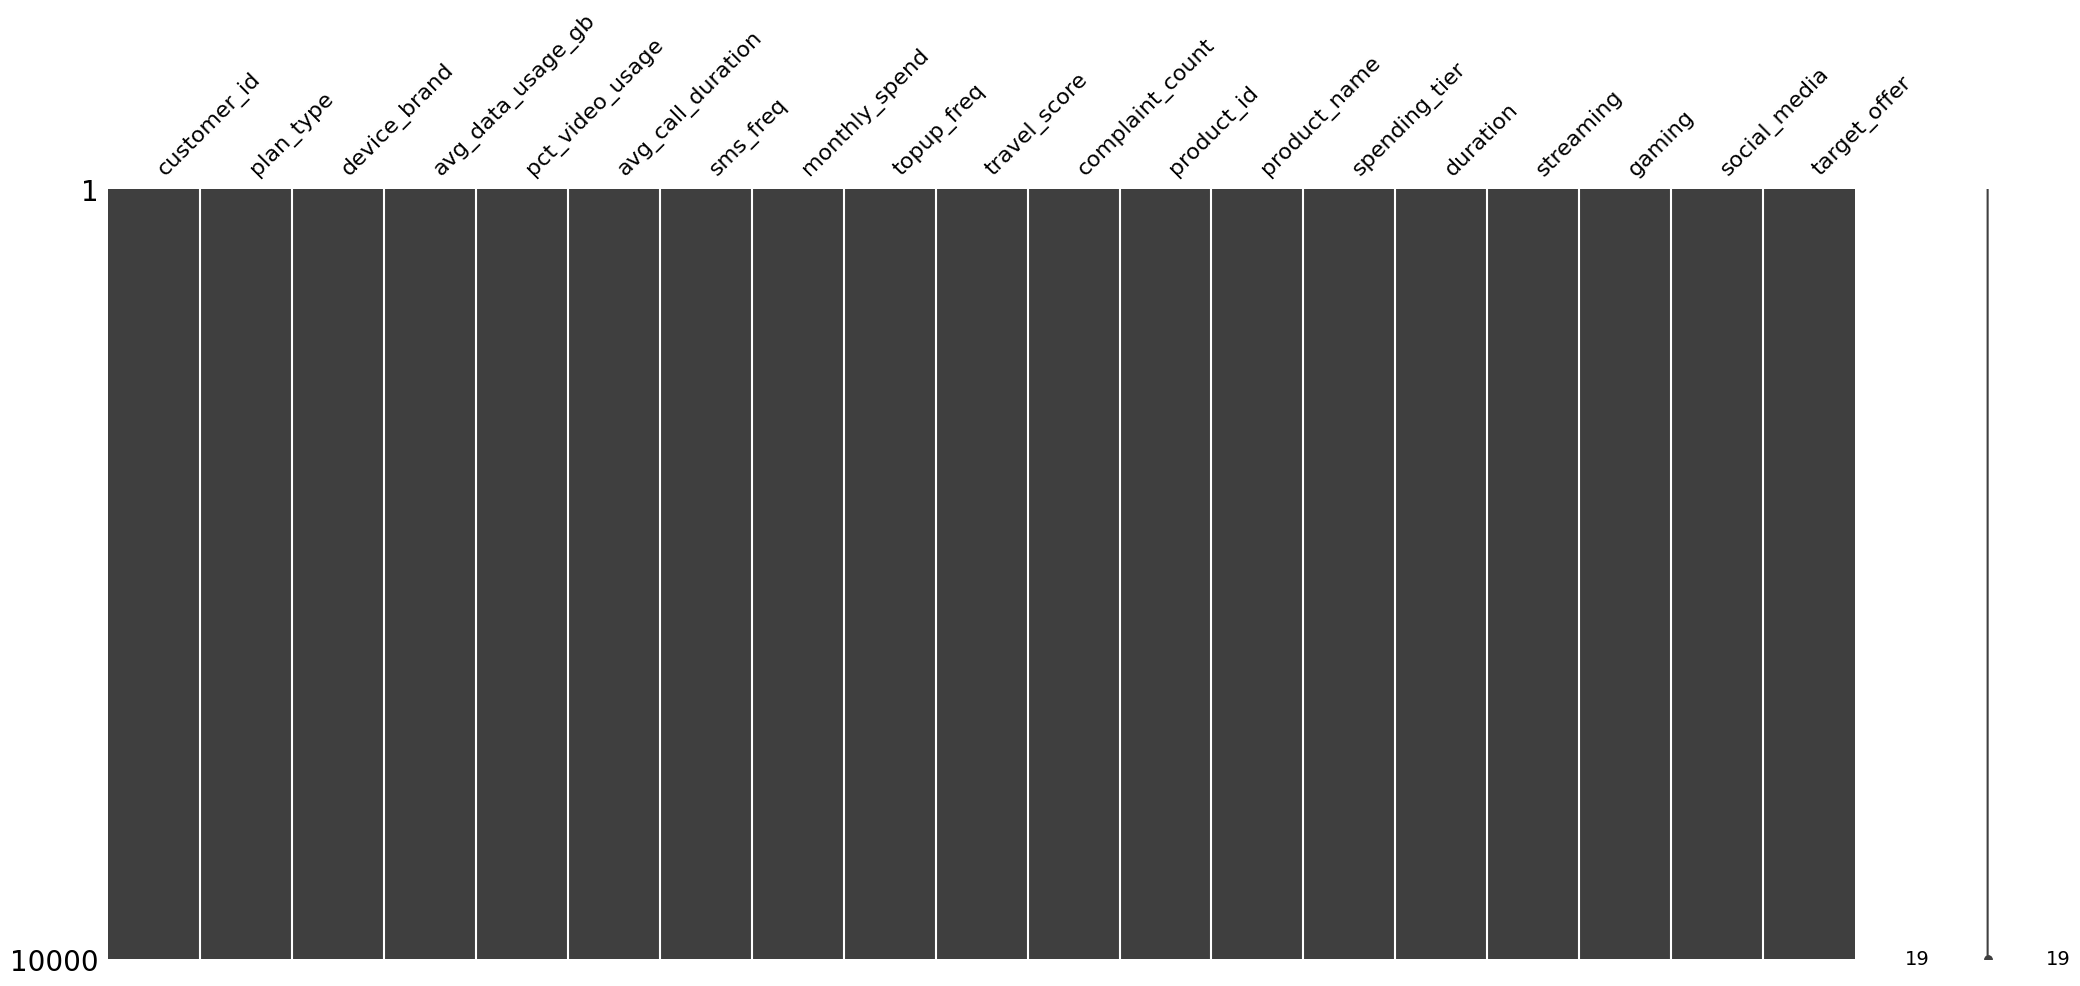

In [6]:
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)

missing_df = (
    pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})
      .query("missing_count > 0")
)
display(missing_df.head(30))
msno.matrix(df)
plt.show()

## Split data jadi kategori dan numerikal

In [7]:
num_cols = df.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["int64", "float64", "int32", "float32"]).columns.tolist()

print("Numeric columns:", len(num_cols))
print(num_cols)
print("\nCategorical columns:", len(cat_cols))
print(cat_cols)

Numeric columns: 9
['avg_data_usage_gb', 'pct_video_usage', 'avg_call_duration', 'sms_freq', 'monthly_spend', 'topup_freq', 'travel_score', 'complaint_count', 'product_id']

Categorical columns: 10
['customer_id', 'plan_type', 'device_brand', 'product_name', 'spending_tier', 'duration', 'streaming', 'gaming', 'social_media', 'target_offer']


In [8]:
num_desc = df[num_cols].describe(
    percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
).T.sort_index()
display(num_desc)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
avg_call_duration,10000.0,9.971357,4.954993,-8.370000,-1.440400,1.740000,6.650000,10.020000,13.320000,18.020000,21.170000,27.770000
avg_data_usage_gb,10000.0,5.958883,4.192909,0.030000,0.450000,1.130000,2.870000,4.990000,8.040000,14.190000,19.730200,39.020000
complaint_count,10000.0,0.492600,0.704127,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,5.000000
monthly_spend,10000.0,109776.500000,46237.321903,-13000.000000,32000.000000,49000.000000,78000.000000,102000.000000,135000.000000,196000.000000,250010.000000,450000.000000
pct_video_usage,10000.0,0.402639,0.195741,0.000000,0.000000,0.070405,0.265290,0.400116,0.535161,0.726821,0.878767,1.000000
product_id,10000.0,12.886000,7.167827,1.000000,1.000000,2.000000,7.000000,13.000000,19.000000,24.000000,25.000000,25.000000
sms_freq,10000.0,15.010800,3.872775,4.000000,7.000000,9.000000,12.000000,15.000000,18.000000,22.000000,25.000000,31.000000
topup_freq,10000.0,2.986600,1.709828,0.000000,0.000000,1.000000,2.000000,3.000000,4.000000,6.000000,8.000000,12.000000
travel_score,10000.0,0.282441,0.158366,0.003376,0.026251,0.061392,0.158775,0.261206,0.385656,0.574364,0.702821,0.854814


## cek data kategori dan ringkasanya

In [9]:
cat_summary_rows = []
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    cat_summary_rows.append({
        "col": c,
        "n_unique": df[c].nunique(dropna=False),
        "top_5": vc.head(5).to_dict()
    })

cat_summary_df = pd.DataFrame(cat_summary_rows).set_index("col")
display(cat_summary_df)

high_card = cat_summary_df[cat_summary_df["n_unique"] > 50]
display(high_card)

,n_unique,top_5
col,,
customer_id,10000,"{'C00001': 1, 'C06671': 1, 'C06664': 1, 'C0666..."
plan_type,2,"{'Prepaid': 6108, 'Postpaid': 3892}"
device_brand,7,"{'Realme': 1509, 'Xiaomi': 1458, 'Samsung': 14..."
product_name,25,"{'100gb 220k (internet only 7)': 434, '90gb 24..."
spending_tier,3,"{'mid': 5597, 'low': 2677, 'high': 1726}"
duration,4,"{'30 hari': 5287, '7 hari': 2323, '1 hari': 15..."
streaming,2,"{'no': 6379, 'yes': 3621}"
gaming,2,"{'no': 7950, 'yes': 2050}"
social_media,2,"{'no': 8007, 'yes': 1993}"


,n_unique,top_5
col,,
customer_id,10000,"{'C00001': 1, 'C06671': 1, 'C06664': 1, 'C0666..."


In [10]:
cat_summary = {}
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    cat_summary[c] = {
        "n_unique": df[c].nunique(dropna=False),
        "top_5": vc.head(5).to_dict()
    }

pd.DataFrame(cat_summary).T

,n_unique,top_5
customer_id,10000,"{'C00001': 1, 'C06671': 1, 'C06664': 1, 'C0666..."
plan_type,2,"{'Prepaid': 6108, 'Postpaid': 3892}"
device_brand,7,"{'Realme': 1509, 'Xiaomi': 1458, 'Samsung': 14..."
product_name,25,"{'100gb 220k (internet only 7)': 434, '90gb 24..."
spending_tier,3,"{'mid': 5597, 'low': 2677, 'high': 1726}"
duration,4,"{'30 hari': 5287, '7 hari': 2323, '1 hari': 15..."
streaming,2,"{'no': 6379, 'yes': 3621}"
gaming,2,"{'no': 7950, 'yes': 2050}"
social_media,2,"{'no': 8007, 'yes': 1993}"
target_offer,5,"{'General Offer': 5607, 'Allrounder offer': 20..."


In [11]:
cat_summary_rows = []
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    cat_summary_rows.append({
        "col": c,
        "n_unique": df[c].nunique(dropna=False),
        "top_5": vc.head(5).to_dict()
    })

cat_summary_df = pd.DataFrame(cat_summary_rows).set_index("col")
display(cat_summary_df)

,n_unique,top_5
col,,
customer_id,10000,"{'C00001': 1, 'C06671': 1, 'C06664': 1, 'C0666..."
plan_type,2,"{'Prepaid': 6108, 'Postpaid': 3892}"
device_brand,7,"{'Realme': 1509, 'Xiaomi': 1458, 'Samsung': 14..."
product_name,25,"{'100gb 220k (internet only 7)': 434, '90gb 24..."
spending_tier,3,"{'mid': 5597, 'low': 2677, 'high': 1726}"
duration,4,"{'30 hari': 5287, '7 hari': 2323, '1 hari': 15..."
streaming,2,"{'no': 6379, 'yes': 3621}"
gaming,2,"{'no': 7950, 'yes': 2050}"
social_media,2,"{'no': 8007, 'yes': 1993}"


High card (kategori paling unik, dimana customer id adalah id yang paling unik)

In [12]:
high_card = cat_summary_df[cat_summary_df["n_unique"] > 50]
display(high_card)

,n_unique,top_5
col,,
customer_id,10000,"{'C00001': 1, 'C06671': 1, 'C06664': 1, 'C0666..."


# **Top Product yang paling banyak dibeli**

In [13]:
top_products = (
    df.groupby(["product_id", "product_name"], dropna=False)
      .size()
      .sort_values(ascending=False)
      .head(4)
)
top_products

,,0
product_id,product_name,
7,100gb 220k (internet only 7),434
12,"90gb 240k (60gb internet + 10gb stream + 10gb game + 10gb socmed, pahe 4)",431
3,25gb 80k (internet only 3),426
14,5gb 10k (internet only harian 1),419


# **Boxplot dan histogram untuk numerikal**

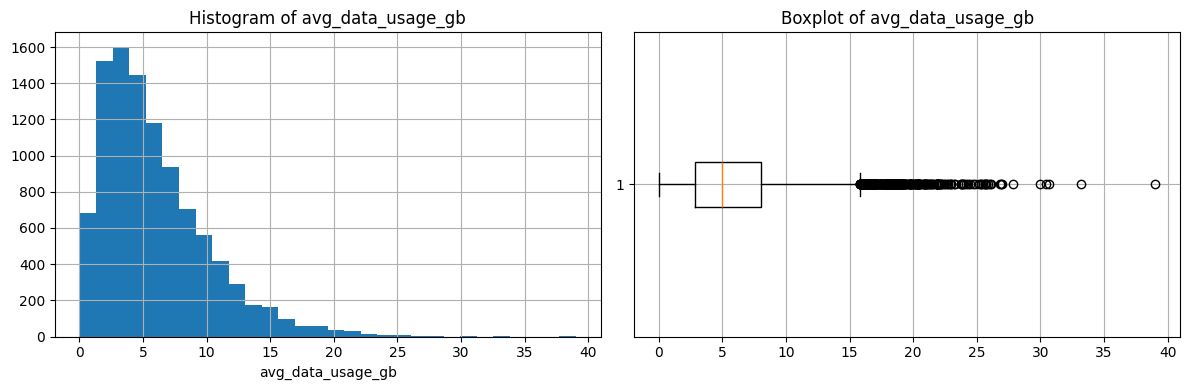

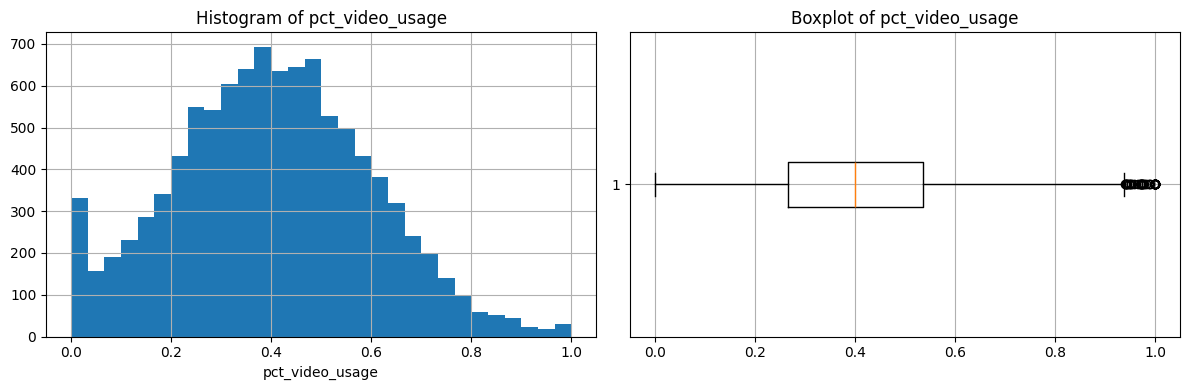

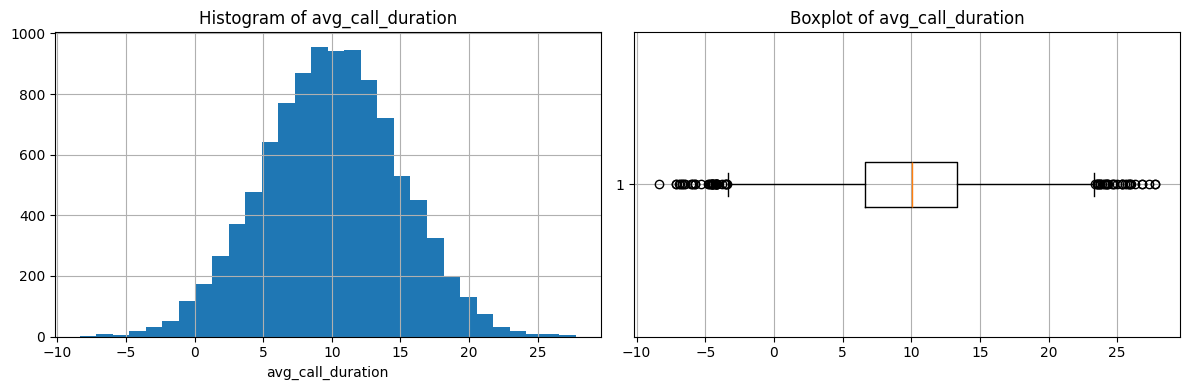

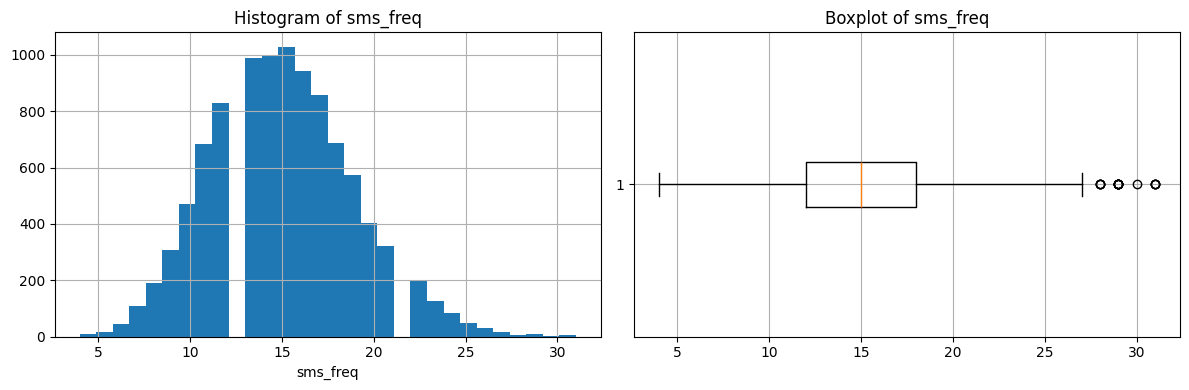

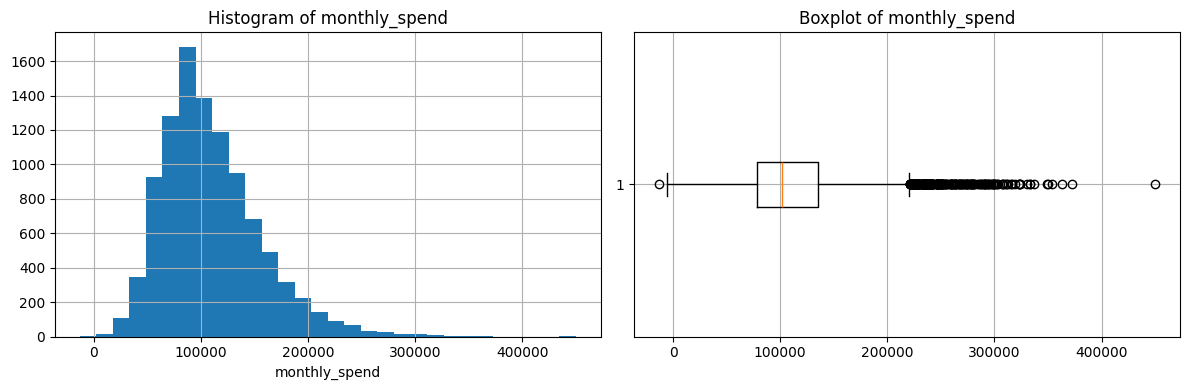

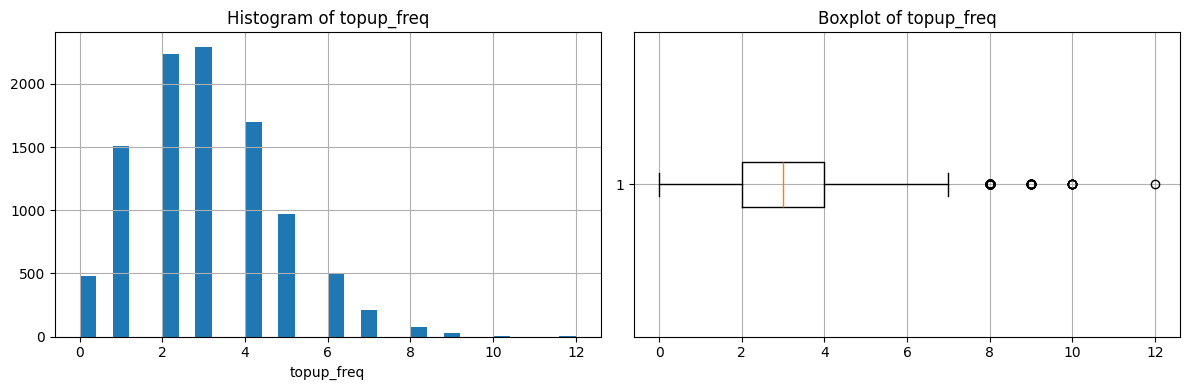

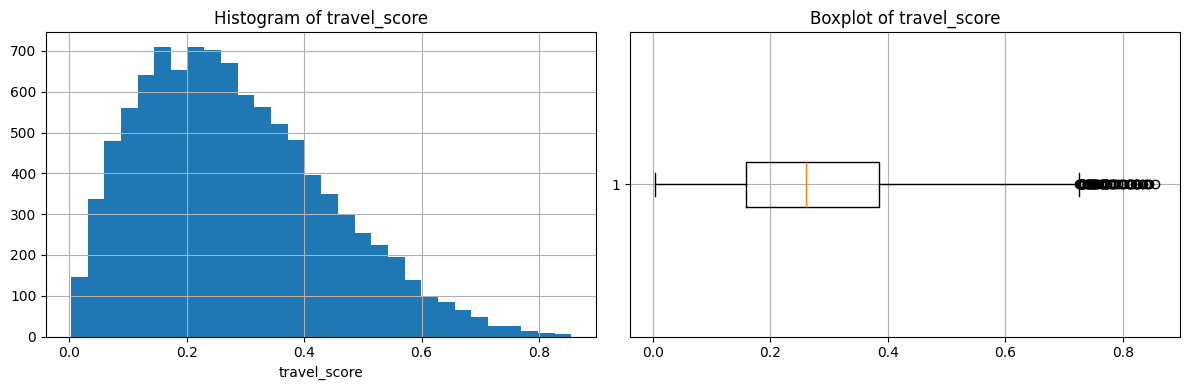

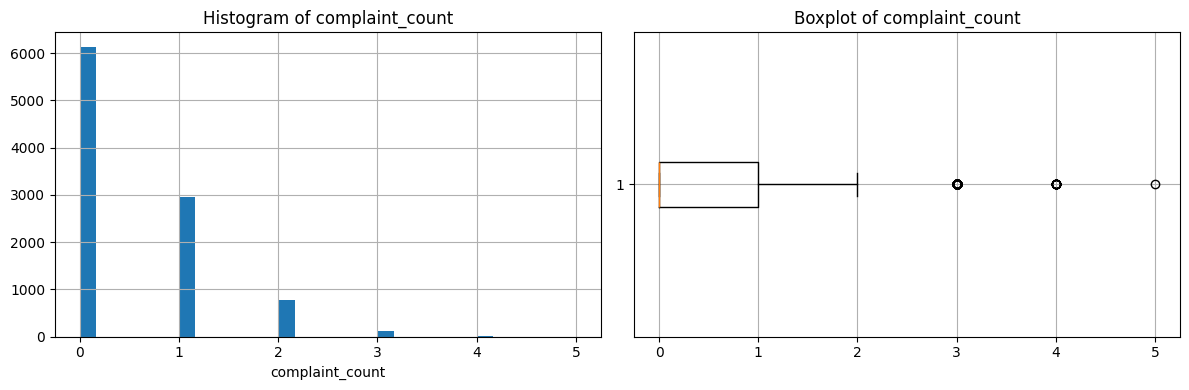

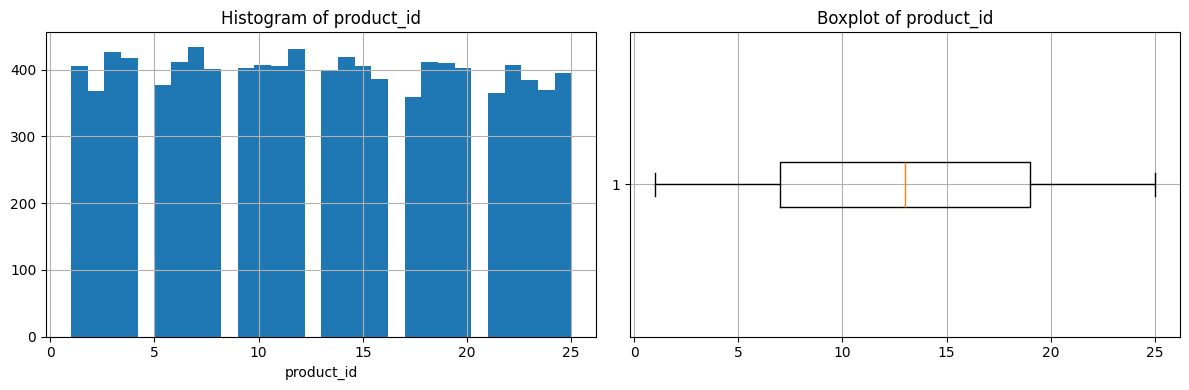

In [14]:
for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    #histogram
    df[col].hist(bins=30, ax=ax[0])
    ax[0].set_title(f"Histogram of {col}")
    ax[0].set_xlabel(col)

    #boxplot
    ax[1].boxplot(df[col].dropna(), vert=False)
    ax[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

# Barplot untuk data kategorikal

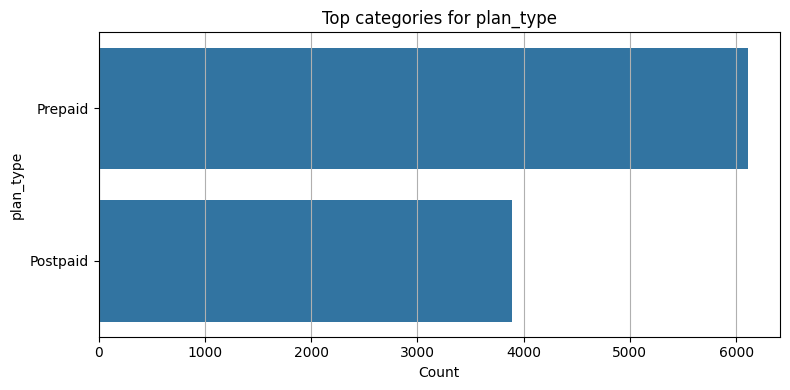

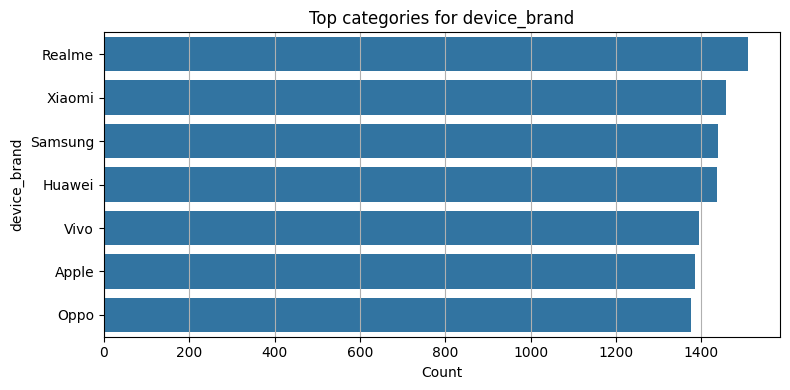

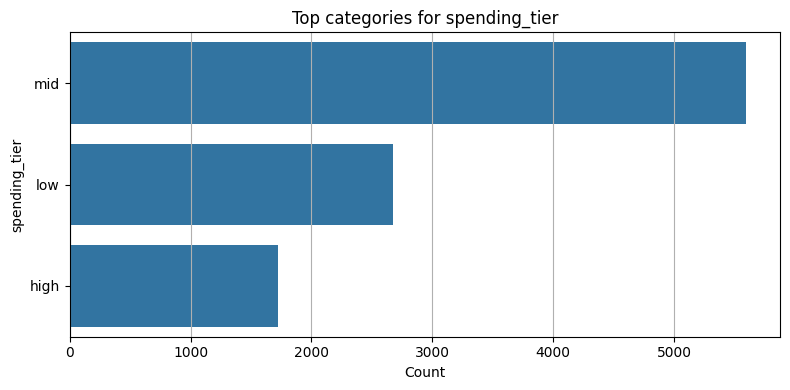

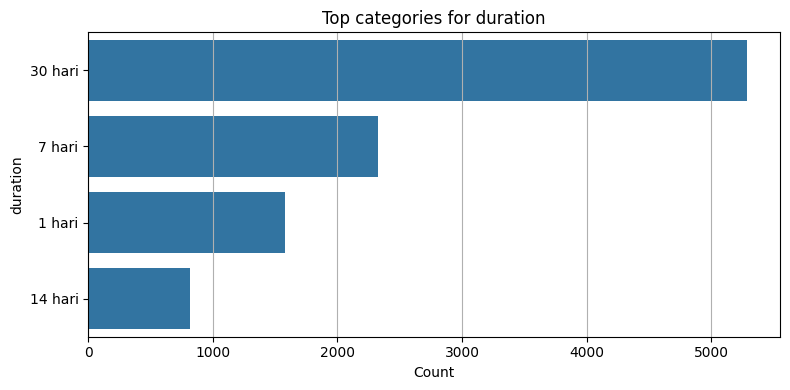

In [15]:
cat_to_plot = [c for c in cat_cols if df[c].nunique(dropna=False) <= 20][:4]

for c in cat_to_plot:
    vc = df[c].value_counts(dropna=False).head(10)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=vc.values, y=vc.index)
    plt.title(f"Top categories for {c}")
    plt.xlabel("Count")
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()

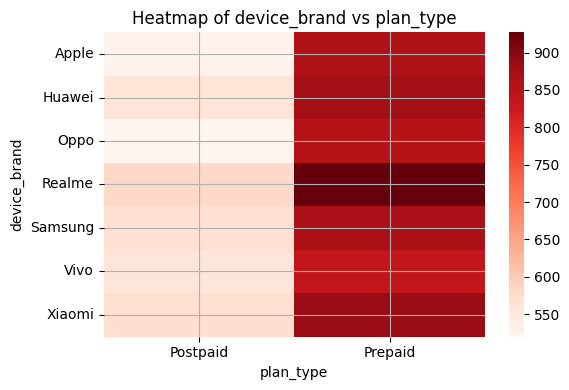

In [16]:
cat_small = [c for c in cat_cols if df[c].nunique(dropna=False) <= 15]

if len(cat_small) >= 2:
    col_x = cat_small[0]
    col_y = cat_small[1]

    ct = pd.crosstab(df[col_y], df[col_x])
    plt.figure(figsize=(6, 4))
    sns.heatmap(ct, annot=False, cmap="Reds")
    plt.title(f"Heatmap of {col_y} vs {col_x}")
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.tight_layout()
    plt.show()
else:
    print("tidak bisa bikin heatmap.")

# Correlation Matrix untuk keseluruhan dan untuk numerikal

In [17]:
df_corr = df.copy()
for c in df_corr.columns:
    if df_corr[c].dtype == "object":
        vals = df_corr[c].dropna().str.lower().unique()
        if set(vals) <= {"yes", "no"}:
            df_corr[c] = df_corr[c].str.lower().map({"no": 0, "yes": 1})


small_cats = [c for c in df_corr.columns
              if df_corr[c].dtype == "object" and df_corr[c].nunique() <= 15]

for c in small_cats:
    df_corr[c] = df_corr[c].astype("category").cat.codes

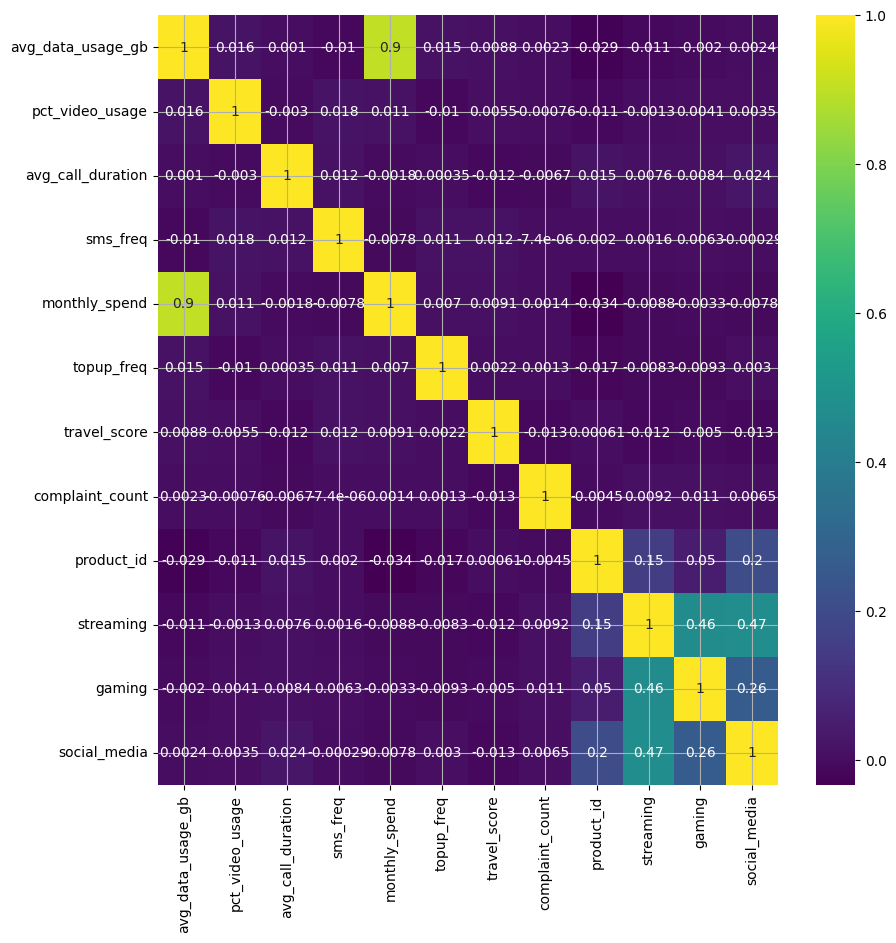

In [18]:
num_like = df_corr.select_dtypes(include=["int64", "float64"]).columns
corr = df_corr[num_like].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(
        corr,
        annot=True,
        cmap="viridis",
        xticklabels=True,
        yticklabels=True
    )
plt.show()

# Correlation Matrix untuk Numerical

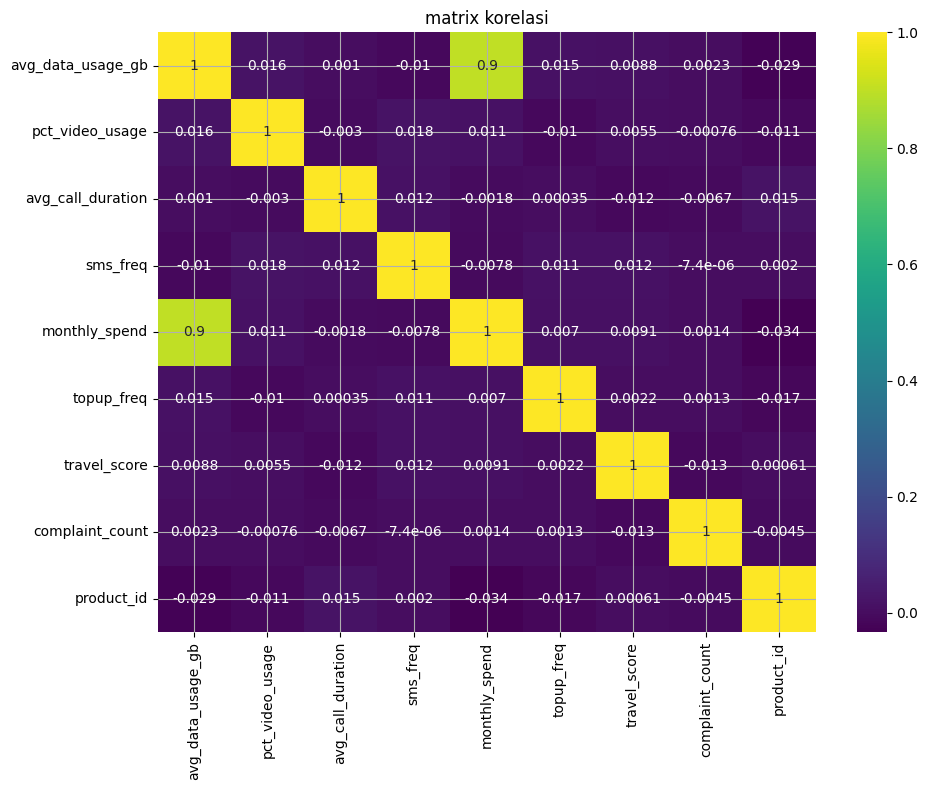

In [19]:
if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr,
        annot=True,
        cmap="viridis",
        xticklabels=True,
        yticklabels=True
    )
    plt.title("matrix korelasi")
    plt.tight_layout()
    plt.show()
else:
    print("tidak bisa bikin matrix korelasi.")

## Test Modelling

In [20]:
SEG_COL = "plan_type"
N = 10
seg_top = (
    df.groupby(SEG_COL)["product_id"]
      .value_counts()
      .groupby(level=0)
      .head(N)
      .reset_index(name="pop_score")
)

users = df[["customer_id", SEG_COL]].drop_duplicates()

candidates = users.merge(
    seg_top,
    on=SEG_COL,
    how="left"
)[["customer_id", "product_id", "pop_score"]]

display(candidates.head())
print("candidates shape:", candidates.shape)

,customer_id,product_id,pop_score
0,C00001,12,267
1,C00001,14,266
2,C00001,4,263
3,C00001,3,260
4,C00001,16,259


candidates shape: (100000, 3)


In [21]:
ranking_df = candidates.merge(df, on=["customer_id", "product_id"], how="left")

In [22]:
# actual product per user
actual = df[["customer_id", "product_id"]].rename(columns={"product_id": "actual_product_id"})

# add actual product info to candidate rows
candidates2 = candidates.merge(actual, on="customer_id", how="left")

# rows where candidate != actual → we need to add the actual one
missing_mask = candidates2["product_id"] != candidates2["actual_product_id"]

# make rows with the actual product
forced = (
    candidates2.loc[missing_mask, ["customer_id", "actual_product_id"]]
    .drop_duplicates()
    .rename(columns={"actual_product_id": "product_id"})
)
forced["pop_score"] = 9999  # so we know it's the real one

# final candidates
candidates_final = (
    pd.concat([candidates, forced], ignore_index=True)
      .drop_duplicates(subset=["customer_id", "product_id"])
)

print("candidates_final shape:", candidates_final.shape)
candidates_final.head()


candidates_final shape: (105764, 3)


,customer_id,product_id,pop_score
0,C00001,12,267
1,C00001,14,266
2,C00001,4,263
3,C00001,3,260
4,C00001,16,259


# Labeling

In [23]:
train_pairs = candidates_final.merge(
    actual,  # from cell 7
    on="customer_id",
    how="left"
)

train_pairs["label"] = (train_pairs["product_id"] == train_pairs["actual_product_id"]).astype(int)
train_pairs.head()
train_pairs["label"].value_counts()

,count
label,
0,95764
1,10000


In [24]:

user_features = (
    df.drop_duplicates(subset=["customer_id"])
      .set_index("customer_id")
      .drop(columns=["product_id"], errors="ignore")
)

product_features = (
    df.drop_duplicates(subset=["product_id"])
      .set_index("product_id")
)

train_df = (
    train_pairs
    .join(user_features, on="customer_id", rsuffix="_user")
    .join(product_features, on="product_id", rsuffix="_item")
)

train_df.head()

,customer_id,product_id,pop_score,actual_product_id,label,plan_type,device_brand,avg_data_usage_gb,pct_video_usage,avg_call_duration,...,topup_freq_item,travel_score_item,complaint_count_item,product_name_item,spending_tier_item,duration_item,streaming_item,gaming_item,social_media_item,target_offer_item
0,C00001,12,267,1,0,Prepaid,Realme,1.5,0.804146,7.98,...,4,0.415110,0,90gb 240k (60gb internet + 10gb stream + 10gb ...,mid,30 hari,yes,yes,yes,Allrounder offer
1,C00001,14,266,1,0,Prepaid,Realme,1.5,0.804146,7.98,...,5,0.331373,0,5gb 10k (internet only harian 1),low,1 hari,no,no,no,General Offer
2,C00001,4,263,1,0,Prepaid,Realme,1.5,0.804146,7.98,...,2,0.443009,1,35gb 100k (internet only 4),low,30 hari,no,no,no,General Offer
3,C00001,3,260,1,0,Prepaid,Realme,1.5,0.804146,7.98,...,1,0.260637,0,25gb 80k (internet only 3),high,30 hari,no,no,no,General Offer
4,C00001,16,259,1,0,Prepaid,Realme,1.5,0.804146,7.98,...,5,0.174001,0,8gb 25k (internet only mingguan 1),mid,7 hari,no,no,no,General Offer


In [25]:
product_features = (
    df
    .drop_duplicates(subset=["product_id"])
    .set_index("product_id")
)

product_features.head()

,customer_id,plan_type,device_brand,avg_data_usage_gb,pct_video_usage,avg_call_duration,sms_freq,monthly_spend,topup_freq,travel_score,complaint_count,product_name,spending_tier,duration,streaming,gaming,social_media,target_offer
product_id,,,,,,,,,,,,,,,,,,
1,C00001,Prepaid,Realme,1.50,0.804146,7.98,13,70000,4,0.284419,0,10gb 50k (internet only 1),low,30 hari,no,no,no,General Offer
18,C00002,Postpaid,Vivo,1.09,0.107686,9.56,9,63000,3,0.115086,0,20gb 45k (internet + stream mingguan),low,7 hari,yes,no,no,Streaming partner offer
15,C00003,Postpaid,Xiaomi,3.24,0.313894,4.61,13,89000,7,0.402998,0,10gb 15k (internet only harian 2),mid,1 hari,no,no,no,General Offer
2,C00004,Prepaid,Apple,5.32,0.420158,6.96,8,67000,4,0.302169,0,15gb 65k (internet only 2),low,30 hari,no,no,no,General Offer
23,C00005,Prepaid,Huawei,1.91,0.251638,11.01,21,72000,5,0.487911,0,3gb 8k (internet only hemat 1),low,1 hari,no,no,no,General Offer


# **Training Pair**

In [26]:
train_df = train_pairs.join(user_features, on="customer_id", rsuffix="_user")
train_df = train_df.join(product_features, on="product_id", rsuffix="_item")
train_df = train_df.drop(columns=["actual_product_id"], errors="ignore")

train_df.head()

,customer_id,product_id,pop_score,label,plan_type,device_brand,avg_data_usage_gb,pct_video_usage,avg_call_duration,sms_freq,...,topup_freq_item,travel_score_item,complaint_count_item,product_name_item,spending_tier_item,duration_item,streaming_item,gaming_item,social_media_item,target_offer_item
0,C00001,12,267,0,Prepaid,Realme,1.5,0.804146,7.98,13,...,4,0.415110,0,90gb 240k (60gb internet + 10gb stream + 10gb ...,mid,30 hari,yes,yes,yes,Allrounder offer
1,C00001,14,266,0,Prepaid,Realme,1.5,0.804146,7.98,13,...,5,0.331373,0,5gb 10k (internet only harian 1),low,1 hari,no,no,no,General Offer
2,C00001,4,263,0,Prepaid,Realme,1.5,0.804146,7.98,13,...,2,0.443009,1,35gb 100k (internet only 4),low,30 hari,no,no,no,General Offer
3,C00001,3,260,0,Prepaid,Realme,1.5,0.804146,7.98,13,...,1,0.260637,0,25gb 80k (internet only 3),high,30 hari,no,no,no,General Offer
4,C00001,16,259,0,Prepaid,Realme,1.5,0.804146,7.98,13,...,5,0.174001,0,8gb 25k (internet only mingguan 1),mid,7 hari,no,no,no,General Offer


# **Persiapan Modelling**

In [27]:
drop_cols = [
    "label","customer_id","actual_product_id","product_name","general_offer","pop_score"
]
y_all     = train_df["label"]
groups    = train_df["customer_id"]
X_all     = train_df.drop(columns=drop_cols, errors="ignore")

X_all_enc = pd.get_dummies(X_all, drop_first=True)


In [52]:
feature_blueprint = X_all_enc.columns.tolist()

# **Split by Customers**

In [28]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X_all_enc, y_all, groups))

X_train, X_val = X_all_enc.iloc[train_idx], X_all_enc.iloc[val_idx]
y_train, y_val = y_all.iloc[train_idx], y_all.iloc[val_idx]
groups_val = groups.iloc[val_idx]


# **Training Model**

# **2 CODE INI HELPER AJA**

In [37]:
def eval_at_threshold(y_true, y_proba, name="Model", threshold=0.5, show_report=True):
    y_pred = (y_proba >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_proba)
    acc = accuracy_score(y_true, y_pred)

    print(f"=== {name} @ threshold={threshold:.4f} ===")
    print("Validation ROC AUC:", round(auc, 4))
    print("Accuracy:", round(acc, 4))
    if show_report:
        print(classification_report(y_true, y_pred))
    return {
        "name": name,
        "threshold": threshold,
        "auc": auc,
        "accuracy": acc
    }

In [38]:
def find_threshold_with_acc_constraint(y_true, y_proba, min_acc=0.95, name="Model"):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    best = None

    for p, r, t in zip(prec[:-1], rec[:-1], thr):
        y_pred_t = (y_proba >= t).astype(int)
        acc = accuracy_score(y_true, y_pred_t)
        if acc >= min_acc:
            f1 = f1_score(y_true, y_pred_t)
            if (best is None) or (f1 > best["f1"]):
                best = {
                    "threshold": float(t),
                    "precision": float(p),
                    "recall": float(r),
                    "f1": float(f1),
                    "accuracy": float(acc),
                }

    if best is None:
        print(f"[{name}] No threshold found with accuracy >= {min_acc}. Using 0.5.")
        t = 0.5
        y_pred_t = (y_proba >= t).astype(int)
        best = {
            "threshold": t,
            "precision": precision_score(y_true, y_pred_t),
            "recall": recall_score(y_true, y_pred_t),
            "f1": f1_score(y_true, y_pred_t),
            "accuracy": accuracy_score(y_true, y_pred_t),
        }

    print(f"[{name}] Best threshold with acc >= {min_acc}:")
    print(best)
    return best


BARU BENERAN MULAI TRAINING DAN COBA COBA

In [39]:
model = XGBClassifier(
    n_estimators=400, learning_rate=0.08, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="logloss", tree_method="hist", random_state=SEED
)
model.fit(X_train, y_train)

y_val_proba = model.predict_proba(X_val)[:, 1]

# default evaluation at 0.5, should already be ~97% accuracy
baseline_default = eval_at_threshold(y_val, y_val_proba, name="Baseline", threshold=0.5)

=== Baseline @ threshold=0.5000 ===
Validation ROC AUC: 0.9895
Accuracy: 0.9679
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     19168
           1       0.90      0.74      0.81      2000

    accuracy                           0.97     21168
   macro avg       0.94      0.87      0.90     21168
weighted avg       0.97      0.97      0.97     21168



In [40]:
best_base = find_threshold_with_acc_constraint(
    y_val, y_val_proba, min_acc=0.95, name="Baseline"
)

best_t = best_base["threshold"]

# optional: show full report at the chosen threshold
baseline_best = eval_at_threshold(
    y_val, y_val_proba,
    name="Baseline (acc>=0.95 tuned)",
    threshold=best_t,
    show_report=True
)


[Baseline] Best threshold with acc >= 0.95:
{'threshold': 0.3148255944252014, 'precision': 0.8097514340344169, 'recall': 0.847, 'f1': 0.8279569892473119, 'accuracy': 0.9667422524565382}
=== Baseline (acc>=0.95 tuned) @ threshold=0.3148 ===
Validation ROC AUC: 0.9895
Accuracy: 0.9667
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19168
           1       0.81      0.85      0.83      2000

    accuracy                           0.97     21168
   macro avg       0.90      0.91      0.90     21168
weighted avg       0.97      0.97      0.97     21168



In [41]:
val_idx_abs = X_val.index

val_frame = pd.DataFrame({
    "customer_id": train_df.loc[val_idx_abs, "customer_id"].values,
    "product_id":  train_df.loc[val_idx_abs, "product_id"].values,
    "label":       y_val.values,
    "score":       y_val_proba
})

gated = val_frame[val_frame["score"] >= best_t].copy()

top1 = (gated.sort_values(["customer_id","score"], ascending=[True, False])
               .groupby("customer_id").head(1))

user_top1_precision = float(top1["label"].mean())
coverage = float(top1["customer_id"].nunique() / val_frame["customer_id"].nunique())

print({
    "User_Top1_Precision (HitRate@1 over recommended)": round(user_top1_precision,4),
    "Coverage_of_users_recommended": round(coverage,4)
})


{'User_Top1_Precision (HitRate@1 over recommended)': 0.9591, 'Coverage_of_users_recommended': 0.867}


In [42]:
M = 10
SEED = 42
train_abs_idx = X_train.index
train_all = train_df.loc[train_abs_idx].copy()

pos = train_all[train_all["label"] == 1]
neg = (train_all[train_all["label"] == 0]
       .groupby("customer_id", group_keys=False)
       .apply(lambda g: g.sample(n=min(M, len(g)), random_state=SEED)))

balanced = pd.concat([pos, neg], ignore_index=True)

y_bal = balanced["label"]
X_bal = balanced.drop(
    columns=["label","customer_id","actual_product_id","product_name","general_offer","pop_score"],
    errors="ignore"
)
X_bal = pd.get_dummies(X_bal, drop_first=True)
missing_cols = [c for c in X_train.columns if c not in X_bal.columns]
for c in missing_cols:
    X_bal[c] = 0
X_bal = X_bal[X_train.columns]

model_prec = XGBClassifier(
    n_estimators=300, learning_rate=0.08, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    min_child_weight=3, gamma=1.0, reg_alpha=0.0, reg_lambda=1.0,
    eval_metric="logloss", tree_method="hist", random_state=SEED
)
model_prec.fit(X_bal, y_bal)
y_val_proba_prec = model_prec.predict_proba(X_val)[:, 1]

# membandingkan dengan tresshold 0.5
print("\n=== Comparison at threshold 0.5 ===")
base_05 = eval_at_threshold(y_val, y_val_proba, name="Baseline", threshold=0.5)
prec_05 = eval_at_threshold(y_val, y_val_proba_prec, name="Precision-leaning", threshold=0.5)

# Mencari model yang diatas 95% untuk kedua model
print("\n=== Threshold search with accuracy >= 0.95 ===")
best_base2 = find_threshold_with_acc_constraint(y_val, y_val_proba,      min_acc=0.95, name="Baseline")
best_prec2 = find_threshold_with_acc_constraint(y_val, y_val_proba_prec, min_acc=0.95, name="Precision-leaning")

# full report
eval_at_threshold(y_val, y_val_proba,      name="Baseline tuned",          threshold=best_base2["threshold"])
eval_at_threshold(y_val, y_val_proba_prec, name="Precision-leaning tuned", threshold=best_prec2["threshold"])




=== Comparison at threshold 0.5 ===
=== Baseline @ threshold=0.5000 ===
Validation ROC AUC: 0.9895
Accuracy: 0.9679
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     19168
           1       0.90      0.74      0.81      2000

    accuracy                           0.97     21168
   macro avg       0.94      0.87      0.90     21168
weighted avg       0.97      0.97      0.97     21168

=== Precision-leaning @ threshold=0.5000 ===
Validation ROC AUC: 0.9897
Accuracy: 0.9676
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     19168
           1       0.90      0.74      0.81      2000

    accuracy                           0.97     21168
   macro avg       0.94      0.86      0.90     21168
weighted avg       0.97      0.97      0.97     21168


=== Threshold search with accuracy >= 0.95 ===
[Baseline] Best threshold with acc >= 0.95:
{'threshold': 0.3148255944252014, 'precision': 0

{'name': 'Precision-leaning tuned',
 'threshold': 0.3274376690387726,
 'auc': 0.9897303709307178,
 'accuracy': 0.967828798185941}

# **Ranking model pake HitRate@K, MRR dan NDCG**

In [51]:
val_idx_abs = X_val.index  # absolute index from train_df

val_frame = pd.DataFrame({
    "customer_id": train_df.loc[val_idx_abs, "customer_id"].values,
    "product_id":  train_df.loc[val_idx_abs, "product_id"].values,
    "label":       y_val.values,
    "score":       y_val_proba_prec #pilihanya ini atau y_val_proba
})

def hitrate_at_k(g, k=5):
    return float((g.sort_values("score", ascending=False).head(k)["label"].max()==1))

def mrr_at_k(g, k=10):
    ranked = g.sort_values("score", ascending=False).head(k).reset_index(drop=True)
    hits = np.where(ranked["label"].values==1)[0]
    return 1.0/(hits[0]+1) if len(hits) else 0.0

def ndcg_at_k(g, k=10):
    ranked = g.sort_values("score", ascending=False).head(k).reset_index(drop=True)
    gains = (2**ranked["label"].values - 1)
    discounts = 1/np.log2(np.arange(2, len(ranked)+2))
    dcg = (gains*discounts).sum()
    ideal = 1/np.log2(2) if g["label"].max()==1 else 0.0
    return dcg/ideal if ideal>0 else 0.0

K=5
rank_metrics = val_frame.groupby("customer_id").apply(lambda g: pd.Series({
    f"HitRate@{K}": hitrate_at_k(g, K),
    "MRR@10": mrr_at_k(g, 10),
    "NDCG@10": ndcg_at_k(g, 10),
}))
print("Ranking metrics (mean):\n", rank_metrics.mean().round(4))

# bikin klasifikasi metrik dari row
y_val_pred = (y_val_proba >= 0.5).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average="binary")
top1 = (val_frame.sort_values(["customer_id","score"], ascending=[True, False])
                 .groupby("customer_id").head(1))
top1_acc = top1["label"].mean()
print({
    "Row_Accuracy": round(accuracy_score(y_val, y_val_pred),4),
    "Precision": round(prec,4),
    "Recall": round(rec,4),
    "F1": round(f1,4),
    "Top1_Accuracy(HitRate@1)": round(top1_acc, 4),
})

Ranking metrics (mean):
 HitRate@5    1.0000
MRR@10       0.9385
NDCG@10      0.9543
dtype: float64
{'Row_Accuracy': 0.9679, 'Precision': 0.904, 'Recall': 0.739, 'F1': 0.8132, 'Top1_Accuracy(HitRate@1)': 0.8905}


# **Liat mana yang kuat dan lemah**

In [44]:
SEG_COL = "plan_type"  # or "spending_tier"
val_seg = train_df.loc[val_idx_abs, [ "customer_id", SEG_COL ]].drop_duplicates(subset=["customer_id"])
val_join = val_frame.merge(val_seg, on="customer_id", how="left")

by_seg = val_join.groupby(SEG_COL).apply(
    lambda g: pd.Series({
        f"HitRate@{K}": g.groupby("customer_id").apply(lambda gg: hitrate_at_k(gg, K)).mean(),
        "MRR@10": g.groupby("customer_id").apply(lambda gg: mrr_at_k(gg, 10)).mean(),
        "NDCG@10": g.groupby("customer_id").apply(lambda gg: ndcg_at_k(gg, 10)).mean(),
        "Users": g["customer_id"].nunique()
    })
).sort_values(f"HitRate@{K}", ascending=False)
by_seg

,HitRate@5,MRR@10,NDCG@10,Users
plan_type,,,,
Postpaid,1.0,0.935881,0.952379,785.0
Prepaid,1.0,0.933882,0.950890,1215.0


# **Top-K preview pake product name sama general offers (ini display aja)**

In [45]:
# lookup meskipun general_offer gak ada
cols_we_want = ["product_id","product_name","general_offer","duration","spending_tier"]
cols_in_df   = [c for c in cols_we_want if c in df.columns]
product_lookup = (df[cols_in_df].drop_duplicates(subset=["product_id"]).set_index("product_id"))

topk_val = (val_frame.sort_values(["customer_id","score"], ascending=[True, False])
                     .groupby("customer_id").head(5))
topk_val_disp = topk_val.join(product_lookup, on="product_id")
topk_val_disp.head(20)

,customer_id,product_id,label,score,product_name,duration,spending_tier
20000,C00001,1,1,0.942701,10gb 50k (internet only 1),30 hari,low
3,C00001,3,0,0.156859,25gb 80k (internet only 3),30 hari,high
5,C00001,6,0,0.147623,80gb 200k (internet only 6),30 hari,low
2,C00001,4,0,0.141764,35gb 100k (internet only 4),30 hari,low
1,C00001,14,0,0.007367,5gb 10k (internet only harian 1),1 hari,low
20001,C00004,2,1,0.997267,15gb 65k (internet only 2),30 hari,low
15,C00004,6,0,0.114209,80gb 200k (internet only 6),30 hari,low
12,C00004,4,0,0.113668,35gb 100k (internet only 4),30 hari,low
13,C00004,3,0,0.077798,25gb 80k (internet only 3),30 hari,high
11,C00004,14,0,0.003884,5gb 10k (internet only harian 1),1 hari,low


# **Feature importance**

In [46]:
booster = model.get_booster()
gain = booster.get_score(importance_type="gain")
feat_imp = (pd.DataFrame([{"feature":k, "gain":v} for k,v in gain.items()])
            .sort_values("gain", ascending=False))
feat_imp.head(20)

,feature,gain
56,customer_id_item_C00149,773.588806
37,customer_id_item_C00003,533.549805
38,customer_id_item_C00004,270.719360
87,target_offer_item_Social media offer,268.051178
81,duration_item_30 hari,259.097961
64,product_name_item_10gb 25k (internet + socmed ...,230.140091
84,gaming_item_yes,209.949539
53,customer_id_item_C00078,209.756165
43,customer_id_item_C00012,197.791275
41,customer_id_item_C00008,179.595306


In [47]:
scores = val_frame["score"].values
labels = val_frame["label"].values
best_thr, best_acc = 0.5, 0
for thr in np.linspace(0.1, 0.9, 17):
    acc = accuracy_score(labels, (scores>=thr).astype(int))
    if acc > best_acc: best_acc, best_thr = acc, thr
print({"Best_Row_Accuracy": round(best_acc,4), "Best_Threshold": round(best_thr,2)})

{'Best_Row_Accuracy': 0.9681, 'Best_Threshold': 0.55}


Analisa Error

In [48]:
top1 = (val_frame.sort_values(["customer_id","score"], ascending=[True, False])
                 .groupby("customer_id").head(1))
wrong = top1[top1["label"]==0].merge(product_lookup, on="product_id", how="left")
wrong.head(20)

,customer_id,product_id,label,score,product_name,duration,spending_tier
0,C00013,13,0,0.541011,100gb 250k (60gb internet + 10gb stream + 10g...,30 hari,mid
1,C00021,3,0,0.301363,25gb 80k (internet only 3),30 hari,high
2,C00133,23,0,0.462737,3gb 8k (internet only hemat 1),1 hari,low
3,C00249,7,0,0.150781,100gb 220k (internet only 7),30 hari,mid
4,C00252,6,0,0.304303,80gb 200k (internet only 6),30 hari,low
5,C00334,6,0,0.274360,80gb 200k (internet only 6),30 hari,low
6,C00382,13,0,0.487318,100gb 250k (60gb internet + 10gb stream + 10g...,30 hari,mid
7,C00409,1,0,0.224372,10gb 50k (internet only 1),30 hari,low
8,C00463,3,0,0.164590,25gb 80k (internet only 3),30 hari,high
9,C00488,6,0,0.290827,80gb 200k (internet only 6),30 hari,low


In [53]:
FINAL_MODEL_NAME = "Precision-leaning FINAL"
FINAL_MODEL      = model_prec                 # model terbaikmu
FINAL_THRESHOLD  = float(best_prec2["threshold"])
FINAL_COLUMNS    = list(X_all_enc.columns)    # cetakan biru fitur (kayak X_enc di notebook lain)

print(f"=== {FINAL_MODEL_NAME} @ threshold={FINAL_THRESHOLD:.4f} ===")
final_cls_metrics = eval_at_threshold(
    y_val,
    y_val_proba_prec,          # pakai model precision-leaning
    name=FINAL_MODEL_NAME,
    threshold=FINAL_THRESHOLD,
    show_report=True
)

# 2. Ranking metrics untuk model final ini
val_idx_abs = X_val.index
val_frame_final = pd.DataFrame({
    "customer_id": train_df.loc[val_idx_abs, "customer_id"].values,
    "product_id":  train_df.loc[val_idx_abs, "product_id"].values,
    "label":       y_val.values,
    "score":       y_val_proba_prec,   # konsisten pakai model final
})

def hitrate_at_k(g, k=5):
    return float((g.sort_values("score", ascending=False).head(k)["label"].max() == 1))

def mrr_at_k(g, k=10):
    ranked = g.sort_values("score", ascending=False).head(k).reset_index(drop=True)
    hits = np.where(ranked["label"].values == 1)[0]
    return 1.0 / (hits[0] + 1) if len(hits) else 0.0

def ndcg_at_k(g, k=10):
    ranked = g.sort_values("score", ascending=False).head(k).reset_index(drop=True)
    gains = (2**ranked["label"].values - 1)
    discounts = 1 / np.log2(np.arange(2, len(ranked) + 2))
    dcg = (gains * discounts).sum()
    ideal = 1 / np.log2(2) if g["label"].max() == 1 else 0.0
    return dcg / ideal if ideal > 0 else 0.0

K = 5
rank_metrics_final = val_frame_final.groupby("customer_id").apply(
    lambda g: pd.Series({
        f"HitRate@{K}": hitrate_at_k(g, K),
        "MRR@10":       mrr_at_k(g, 10),
        "NDCG@10":      ndcg_at_k(g, 10),
    })
)

print("\n=== Ranking metrics (Precision-leaning FINAL, user-averaged) ===")
print(rank_metrics_final.mean().round(4))

# Top-1 (HitRate@1) untuk model final
top1_final = (val_frame_final.sort_values(["customer_id", "score"], ascending=[True, False])
                           .groupby("customer_id").head(1))
top1_acc_final = float(top1_final["label"].mean())
print(f"\nTop1_Accuracy (HitRate@1): {top1_acc_final:.4f}")

# 3. Simpan artefak ke PKL (gaya 2/3 file seperti contohmu)
joblib.dump(FINAL_MODEL,   "xgb_precision_leaning.pkl")
joblib.dump(FINAL_COLUMNS, "model_columns.pkl")
joblib.dump(FINAL_THRESHOLD, "model_threshold.pkl")

print("\n=== Artifacts saved ===")
print("  - xgb_precision_leaning.pkl  (model final XGBoost)")
print("  - model_columns.pkl          (cetak biru kolom / one-hot features)")
print("  - model_threshold.pkl        (threshold keputusan untuk label=1)")

=== Precision-leaning FINAL @ threshold=0.3274 ===
=== Precision-leaning FINAL @ threshold=0.3274 ===
Validation ROC AUC: 0.9897
Accuracy: 0.9678
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19168
           1       0.82      0.85      0.83      2000

    accuracy                           0.97     21168
   macro avg       0.90      0.91      0.91     21168
weighted avg       0.97      0.97      0.97     21168


=== Ranking metrics (Precision-leaning FINAL, user-averaged) ===
HitRate@5    1.0000
MRR@10       0.9385
NDCG@10      0.9543
dtype: float64

Top1_Accuracy (HitRate@1): 0.8905

=== Artifacts saved ===
  - xgb_precision_leaning.pkl  (model final XGBoost)
  - model_columns.pkl          (cetak biru kolom / one-hot features)
  - model_threshold.pkl        (threshold keputusan untuk label=1)
